# Tutorial Multispectral Classification

> multispectral classification


In [ ]:
#| default_exp tutorial_multispectral

In [ ]:
from bioMONAI.data import *
from bioMONAI.transforms import *
from bioMONAI.core import *
from bioMONAI.core import Path
from bioMONAI.data import *
from bioMONAI.nets import BasicUNet, DynUNet
from bioMONAI.losses import *
from bioMONAI.losses import SSIMLoss
from bioMONAI.metrics import *
from bioMONAI.datasets import download_file, split_dataframe, add_columns_to_csv

import os


In [ ]:
import warnings
warnings.filterwarnings("ignore")


In [ ]:
device = get_device()
print(device)

cuda


---

In [ ]:
# Define the base URL for the dataset
url = "https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/rxrx1_subset_monai.zip"

download_file(url, "../_data", extract=True, hash='e80db433db641bb390ade991b81f98814a26c7de30e0da6f20e8abddf7a84538', extract_dir='')

The file has been downloaded and saved to: ../_data
Extracted files have been saved to: ../_data


In [ ]:
data_folder = '../_data/rxrx1_subset_monai/'
csv_file = data_folder + 'metadata.csv'

import pandas as pd
df = pd.read_csv(csv_file)

ch1, ch2, ch3, ch4, ch5,ch6 = [],[],[],[],[],[]
for sid in df['site_id']: 
    site_id = sid.split('_')
    base_image_path = os.path.join('images', site_id[0], f'Plate{site_id[1]}', f'{site_id[2]}_s{site_id[3]}_w')
    channel_list = [f'{base_image_path}{i}.png' for i in range(1,7)]
    ch1.append(channel_list[0])
    ch2.append(channel_list[1])
    ch3.append(channel_list[2])
    ch4.append(channel_list[3])
    ch5.append(channel_list[4])
    ch6.append(channel_list[5])
image_paths = {'channel 1': ch1, 'channel 2': ch2, 'channel 3': ch3, 'channel 4': ch4, 'channel 5': ch5, 'channel 6': ch6}
# Let's create a new csv file to avoid overwriting the original one
new_csv_file = data_folder + 'metadata_updated.csv'
add_columns_to_csv(csv_file, image_paths, new_csv_file)


Columns ['channel 1', 'channel 2', 'channel 3', 'channel 4', 'channel 5', 'channel 6'] added successfully. Updated file saved to '../_data/rxrx1_subset_monai/metadata_updated.csv'


In [ ]:
split_dataframe(new_csv_file, 
                train_fraction=0.7, 
                valid_fraction=0.05, 
                split_column='dataset', 
                add_is_valid=True, 
                train_path="train.csv", 
                test_path="test.csv", 
                valid_path="valid.csv", 
                data_save_path=data_folder
                )

Train and test files saved as '../_data/rxrx1_subset_monai/train.csv' and '../_data/rxrx1_subset_monai/test.csv' respectively.
'is_valid' column added to '../_data/rxrx1_subset_monai/train.csv' for validation samples.


In [ ]:
from fastai.vision.all import RandomResizedCrop

bs = 8

itemTfms = [ScaleIntensityPercentiles(1,99), RandomResizedCrop(512,min_scale=0.9, max_scale=1.1), RandRot90(prob=.75), RandFlip(prob=0.5)]
batchTfms = []

data = BioDataLoaders.class_from_csv(
    data_folder,
    'train.csv',
    fn_col=[12,13,14,15,16,17],
    label_col=3,
    valid_col=-1,
    seed=42, 
    img_cls=BioImageMulti,
    item_tfms=itemTfms,
    batch_tfms=batchTfms, 
    show_summary=False,
    bs = bs,
    )

# print length of training and validation datasets
print('train images:', len(data.train_ds.items), '\nvalidation images:', len(data.valid_ds.items))

train images: 929 
validation images: 71


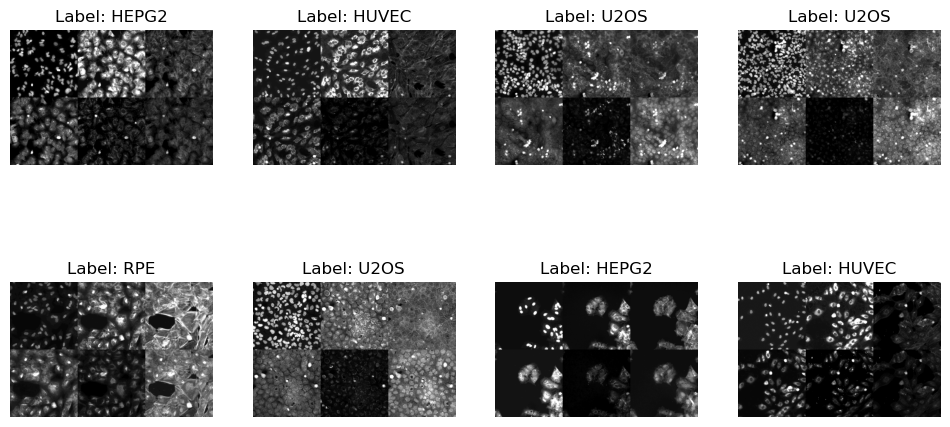

In [ ]:
data.show_batch(max_slices=6, layout='multirow')

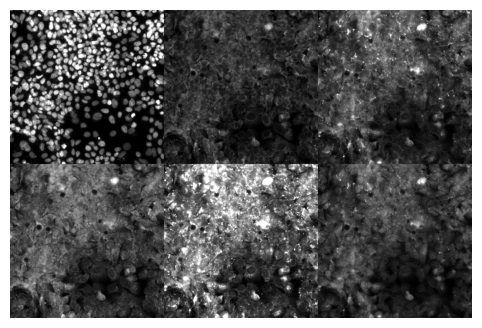

In [ ]:
a = data.do_item(100)
a[0].show(max_slices=6, layout='multirow');

---

In [ ]:
from monai.networks.nets import DenseNet169

model = DenseNet169(spatial_dims=2, in_channels=6, out_channels=data.c, pretrained=True)

In [ ]:
from fastai.vision.all import RocAuc, accuracy
metrics = [RocAuc(), accuracy]

trainer = fastTrainer(data, model, metrics=metrics, show_summary=False)

In [ ]:
trainer.fine_tune(4, freeze_epochs=2)

epoch,train_loss,valid_loss,roc_auc_score,accuracy,time


In [ ]:
trainer.save('multispectral-classification-model')

Path('../_data/rxrx1_subset_monai/models/multispectral-classification-model.pth')

---

In [ ]:
test_data = BioDataLoaders.class_from_csv(
    data_folder,
    'test.csv',
    fn_col=[12,13,14,15,16,17],
    label_col=3,
    valid_pct=0,
    seed=42, 
    img_cls=BioImageMulti,
    item_tfms=[ScaleIntensityPercentiles(1,99)],
    batch_tfms=batchTfms, 
    show_summary=False,
    bs = 50,
    )

              precision    recall  f1-score   support

       HEPG2       0.84      0.86      0.85        50
       HUVEC       0.86      1.00      0.93        50
         RPE       0.64      0.84      0.72        50
        U2OS       1.00      0.50      0.67        50

    accuracy                           0.80       200
   macro avg       0.84      0.80      0.79       200
weighted avg       0.84      0.80      0.79       200


Most Confused Classes:


[('U2OS', 'RPE', 17), ('RPE', 'HUVEC', 8), ('U2OS', 'HEPG2', 8), ('HEPG2', 'RPE', 7)]


,Value
CrossEntropyLossFlat,
Mean,0.961880
Median,0.769793
Standard Deviation,0.330322
Min,0.743672
Max,1.741814
Q1,0.745767
Q3,1.020655


,Value
accuracy,
Mean,0.8
Median,1.0
Standard Deviation,0.4
Min,0.0
Max,1.0
Q1,1.0
Q3,1.0


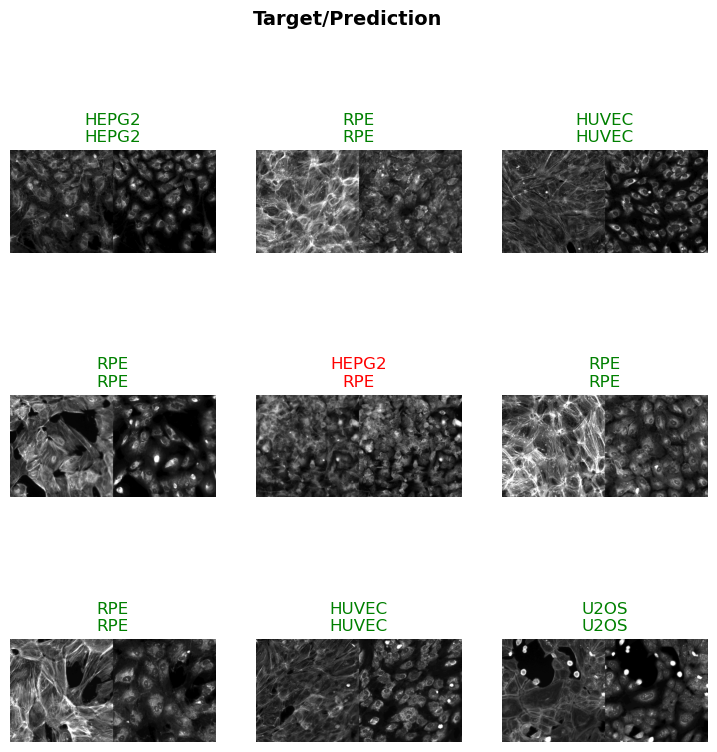

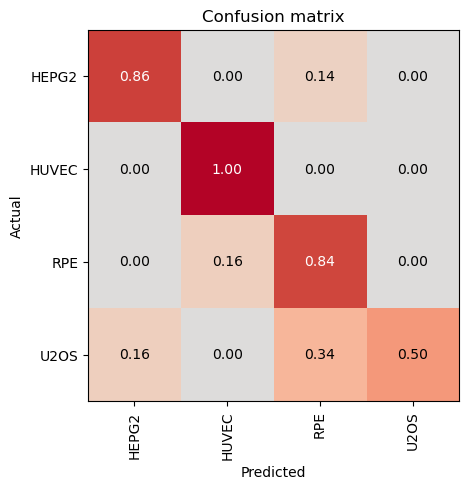

In [ ]:
scores = evaluate_classification_model(trainer, test_data, metrics=accuracy, show_graph=False)